![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/05/logo-upv-horizontal.png)
![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/06/logos-perte-chip-1024x119.png)


# Laboratory 0.2. Couplers

Today, we will take a brief look at two types of couplers used in integrated photonic circuits. We will perform simulations that will allow us to understand how the following operate: 

1. **Directional Couplers (DC)**

2. **Multimode Interferometers (MMIs)**

## 0. Imports 
(Run once  - before running other codes)

In [1]:
try:
  import google.colab
  is_running_on_colab = True
  !sudo apt-get install libglu1-mesa > /dev/null
  !pip install gdsfactory==8.6.1 > /dev/null
  !pip install "gplugins[devsim,femwell,gmsh,schematic,meow,meshwell,ray,sax,tidy3d]" > /dev/null

except ImportError:
  is_running_on_colab = False

### 0.1. General libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tidy3d as td

import gplugins as gp
import gplugins.tidy3d as gt
from gplugins import plot
from gplugins.common.config import PATH

import shapely as shp
import shapely.affinity as shpa
from collections import OrderedDict
from matplotlib.pyplot import cm

from skfem.io.meshio import from_meshio
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains
from femwell.maxwell.waveguide import compute_modes
import femwell.maxwell.waveguide as fmwg

import gplugins.tidy3d.materials as mat

from tqdm.auto import tqdm

from skfem import (
    Basis,
    BilinearForm,
    ElementDG,
    ElementTriN1,
    ElementTriN2,
    ElementTriP0,
    ElementTriP1,
    ElementTriP2,
    ElementVector,
    Functional,
    InteriorFacetBasis,
    LinearForm,
    Mesh,
    condense,
    solve,
)

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from matplotlib.patches import Rectangle

nm = 1e-3
wavelength = np.linspace(1500, 1600) * nm
f = td.C_0 / wavelength

2025-09-11 23:18:04.287 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from C:\Users\camil\.gdsfactory\modes\WaveguideCoupler_e51ab3a5204c1f39.npz.
2025-09-11 23:19:12.321 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into C:\Users\camil\.gdsfactory\modes\Waveguide_bb415d080d176e08.npz.


### 0.2. Functions by us

In [4]:
# This function takes the "mode" resulting from FEMWELL modesovler
# and provides a slight more visible plot of Ex and Ey
# It also anotates the figure thi the effective index and TE/TM fractions
def my_plot_mode(mode, i, xlim = [-2,2], ylim = [-1,1]):
    (Ex, Ey), _ = mode.basis.interpolate(mode.E)
    fig, axs = plt.subplots(1,2,sharey=True, sharex=True)
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')

    (et, et_basis), (ez, ez_basis) = mode.basis.split(mode.E)

    plot_basis = et_basis.with_element(ElementVector(ElementDG(ElementTriP1())))
    et_xy = plot_basis.project(et_basis.interpolate(et))
    (et_x, et_x_basis), (et_y, et_y_basis) = plot_basis.split(et_xy)

    for ax in axs:
        mode.basis.mesh.draw(ax=ax, boundaries_only=True)
        for subdomain in mode.basis.mesh.subdomains.keys() - {"gmsh:bounding_entities"}:
            mode.basis.mesh.restrict(subdomain).draw(ax=ax, boundaries_only=True)

    vmin = np.min((et_x, et_y))
    vmax = np.max((et_x, et_y))

    et_x_basis.plot(et_x, shading="gouraud", ax=axs[0], vmin=np.min(et_x), vmax=np.max(et_x), cmap="bwr")

    ctxt = "black"
    fs = 8

    s = f"Mode # {i}, n_eff = {np.real(mode.n_eff):.4f}"
    axs[0].annotate(s,(-1.95,1.5),color=ctxt, fontsize=fs)
    s = f"TE {mode.te_fraction:.4f}, TM {mode.tm_fraction:.4f}"
    axs[0].annotate(s,(-1.95,1.0),color=ctxt, fontsize=fs)

    et_y_basis.plot(et_y, shading="gouraud", ax=axs[1], vmin=np.min(et_y), vmax=np.max(et_y), cmap="bwr")

    plt.xlim(xlim)
    plt.ylim(ylim)

# Given FEMWELL calcuated modes, return two sets for the TE and TM separated
def get_TETM(modes):
    modes_TE = []
    modes_TM = []
    for i,mode in enumerate(modes):
        if (mode.te_fraction > 0.5):
            modes_TE.append(mode)
        if (mode.tm_fraction >0.5):
            modes_TM.append(mode)
    return modes_TE, modes_TM

# Given a set of modes, identify those whose effective index
# is above certain TOL of the reference index give (e.g. cladding index)
# and thus are considered as guided
def guided_modes(modes, mat_cladd = mat.sio2(1.55), TOL = 1e-2):
    guided_modes = []
    for i,mode in enumerate(modes):
        if ( ( np.real(mode.n_eff) - mat_cladd ) >= TOL):
            guided_modes.append(mode)
    return guided_modes

# This function returns the FEMWELL calucated modes and basis used
# for several parameters
def waveguide(
        wg_width = 1.0,            # waveguide width
        wg_thickness = 0.3,    # waveguide thickness
        x_c = 0.0,             # waveguide center
        wvl = 1.55,                      # wavelength
        mat_core = mat.sin(1.55),        # core material
        mat_shallow = mat.sio2(1.55),    # shallow area material
        mat_cladd = mat.sio2(1.55),      # cladding material
        num_modes = 2,          # number of modes
        sh_width = 10.0,                # the width of the shallow part
        sh_thickness = 0.150,           # thickness of shallow part
        XY = [-1,-1,1,1],               # simulation window
        ENABLE_PLOTS = False           # plot or not
):

        ### Create the polygons representing the waveguide

        # Simulation region corner coordinates
        # x0 = -sh_width/2.0
        # x1 = -x0
        # y0 = -2
        # y1 = -y0
        x0 = XY[0]
        y0 = XY[1]
        x1 = XY[2]
        y1 = XY[3]
        env = shp.box(x0, y0, x1, y1) # env is the actual simulation area

        # Polygons representing the different waveguide regions within the simulation area
        core = shp.box(-wg_width / 2 + x_c, -wg_thickness/2.0, +wg_width / 2 + x_c, +wg_thickness/2.0) # box, but could be something else, e.g. trapezoid
        #shallow = shp.box(-sh_width / 2, 0, +sh_width / 2, sh_thickness)

        # Dictionary with the above
        polygons = OrderedDict(
        core=core,
        #shallow = shallow,
        oxide=shp.clip_by_rect(env, -np.inf, -np.inf, np.inf, np.inf)

        #box=shp.clip_by_rect(env, -np.inf, -np.inf, np.inf, 0), # substrate from below to y = 0
        #clad=shp.clip_by_rect(env, -np.inf, 0, np.inf, np.inf), # clading from y = 0 and above
        )

        # Assign them resolutions
        #resolutions = dict(core={"resolution": 0.1, "distance": 0.5}, shallow={"resolution": 0.1, "distance": 0.5})
        resol_core = wg_thickness / 5
        #resol_shallow = sh_thickness / 5
        resol_oxide = 0.5

        resolutions = dict(
            core={"resolution": resol_core, "distance": 0.5},
            #shallow={"resolution": resol_shallow, "distance": 0.5},
            #box={"resolution": resol_oxide, "distance": 2.0},
            #cladd={"resolution": resol_oxide, "distance": 2.0}
            oxide ={"resolution": resol_oxide, "distance": 2.0}
        )
        # Create mesh with the polygons and the resolutions
        mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))

        if (ENABLE_PLOTS):
                # Plot the mesh
                mesh.draw().show()
                # Identify the different parts of the waveguide
                plot_domains(mesh)
                plt.show()


        # Assign the different materials to the mesh areas:
        basis0 = fmwg.Basis(mesh, fmwg.ElementTriP0()) # extract basis from mesh
        epsilon = basis0.zeros() # set the permitiviy (epsilon) to zero everywhere

        # Iterate over the different parts of the mesh and assign refractive index (note n**2 because femwell expects permitivity)
        #for subdomain, n in {"core": mat_core, "shallow": mat_shallow, "box": mat_cladd, "clad": mat_cladd}.items():
        #for subdomain, n in {"core": mat_core, "box": mat_cladd, "clad": mat_cladd}.items():
        for subdomain, n in {"core": mat_core, "oxide": mat_cladd}.items():
                epsilon[basis0.get_dofs(elements=subdomain)] = n**2

        # Plot permitivity map
        if (ENABLE_PLOTS):
                basis0.plot(epsilon, colorbar=True).show()


        # Find the propagation modes

        modes = fmwg.compute_modes(basis0, epsilon, wavelength=wvl, num_modes=num_modes, order=2)

        guided_m = guided_modes(modes)
        return guided_m, basis0

# This function returns the FEMWELL calucated modes and basis used
# for several parameters
def waveguide_Array(
        wg_width = 1.0,            # waveguide width
        wg_thickness = 0.3,    # waveguide thickness
        wg_gap = 0.8,
        wg_N = 2,
        x_c = 0.0,             # waveguide center
        wvl = 1.55,                      # wavelength
        mat_core = mat.sin(1.55),        # core material
        mat_shallow = mat.sio2(1.55),    # shallow area material
        mat_cladd = mat.sio2(1.55),      # cladding material
        num_modes = 2,          # number of modes
        sh_width = 10.0,                # the width of the shallow part
        sh_thickness = 0.150,           # thickness of shallow part
        XY = [-1,-1,1,1],               # simulation window
        ENABLE_PLOTS = False           # plot or not
):

        ### Create the polygons representing the waveguide

        # Simulation region corner coordinates

        # Polygons representing the different waveguide regions within the simulation area
        cores = []
        wg_d = wg_width + wg_gap
        if wg_N % 2 == 0:  # N is even
            centers = np.arange(-wg_N//2, wg_N//2)+1/2
        else:           # N is odd
            centers = np.arange(-wg_N//2+1, wg_N//2 + 1)
        # print(centers)
           
        centers = centers * wg_d

        padding = 2*wg_width
        x0 = np.min(centers) - (wg_width/2.0 + padding)
        y0 = XY[1]
        x1 = np.max(centers) + (wg_width/2.0 + padding)
        y1 = XY[3]
        XY = [x0,y0,x1,y1]

        env = shp.box(x0, y0, x1, y1) # env is the actual simulation area

        for i in range(0,wg_N):
            cores.append( shp.box(-wg_width / 2 + x_c + centers[i], -wg_thickness/2.0, +wg_width / 2 + x_c + centers[i], +wg_thickness/2.0) )# box, but could be something else, e.g. trapezoid
        #shallow = shp.box(-sh_width / 2, 0, +sh_width / 2, sh_thickness)

        core = shp.ops.unary_union(cores)

        # Dictionary with the above
        polygons = OrderedDict(
        core=core,
        #shallow = shallow,
        oxide=shp.clip_by_rect(env, -np.inf, -np.inf, np.inf, np.inf)

        #box=shp.clip_by_rect(env, -np.inf, -np.inf, np.inf, 0), # substrate from below to y = 0
        #clad=shp.clip_by_rect(env, -np.inf, 0, np.inf, np.inf), # clading from y = 0 and above
        )

        # Assign them resolutions
        #resolutions = dict(core={"resolution": 0.1, "distance": 0.5}, shallow={"resolution": 0.1, "distance": 0.5})
        resol_core = wg_thickness / 5
        #resol_shallow = sh_thickness / 5
        resol_oxide = 0.5

        resolutions = dict(
            core={"resolution": resol_core, "distance": 0.5},
            #shallow={"resolution": resol_shallow, "distance": 0.5},
            #box={"resolution": resol_oxide, "distance": 2.0},
            #cladd={"resolution": resol_oxide, "distance": 2.0}
            oxide ={"resolution": resol_oxide, "distance": 2.0}
        )
        # Create mesh with the polygons and the resolutions
        mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))

        if (ENABLE_PLOTS):
                # Plot the mesh
                mesh.draw().show()
                # Identify the different parts of the waveguide
                plot_domains(mesh)
                plt.show()


        # Assign the different materials to the mesh areas:
        basis0 = fmwg.Basis(mesh, fmwg.ElementTriP0()) # extract basis from mesh
        epsilon = basis0.zeros() # set the permitiviy (epsilon) to zero everywhere

        # Iterate over the different parts of the mesh and assign refractive index (note n**2 because femwell expects permitivity)
        #for subdomain, n in {"core": mat_core, "shallow": mat_shallow, "box": mat_cladd, "clad": mat_cladd}.items():
        #for subdomain, n in {"core": mat_core, "box": mat_cladd, "clad": mat_cladd}.items():
        for subdomain, n in {"core": mat_core, "oxide": mat_cladd}.items():
                epsilon[basis0.get_dofs(elements=subdomain)] = n**2

        # Plot permitivity map
        if (ENABLE_PLOTS):
                basis0.plot(epsilon, colorbar=True).show()


        # Find the propagation modes

        modes = fmwg.compute_modes(basis0, epsilon, wavelength=wvl, num_modes=num_modes, order=2)

        guided_m = guided_modes(modes)
        return guided_m, basis0, XY, centers


# Function to get a 1D slide of mode at the centran coordinate

def slice_mode(mode = [], num_points = 1024, x0=-4, x1=+4, polarization="TE"):
    (Ex, Ey), _ = mode.basis.interpolate(mode.E)
    (et, et_basis), (ez, ez_basis) = mode.basis.split(mode.E)
    plot_basis = et_basis.with_element(ElementVector(ElementDG(ElementTriP1())))
    et_xy = plot_basis.project(et_basis.interpolate(et))
    (et_x, et_x_basis), (et_y, et_y_basis) = plot_basis.split(et_xy)

    # fig, axs = plt.subplots()
   #  print(np)
    N_query_pts = num_points
    x_0 = x0
    x_1 = x1
    x1_value = 0.0
    query_pts = np.vstack([
        np.linspace(x_0,x_1,N_query_pts),  # x[0] coordinate values
        x1_value*np.ones(N_query_pts),  # x[1] coordinate values
    ])
    if polarization == "TE":
        p0_probes = et_x_basis.probes(query_pts)
        e = p0_probes @ et_x
    if polarization == "TM":
        p0_probes = et_y_basis.probes(query_pts)
        e = p0_probes @ et_y
    # axs.plot(query_pts[0], e)
    return query_pts[0], e

def mode_overlap(
          mode_single,
          modes_multiple,
    ):

    num_modes = np.size(modes_multiple)
    ovl = np.zeros((1,num_modes), dtype=np.complex128)
    for j, mode in enumerate(modes_multiple):
        ovl[0][j] = mode_single.calculate_overlap(mode)

    return ovl

def propagate_modes(
        wvl = 1.55,
        dz = 0.05,
        L = 100.0,
        ovl_z_0 = [],
        modes = [],
        slices = []
):
    num_modes = np.size(modes)
    np_z = int(np.round(L/dz))
    L_v = np.linspace(0,L,np_z)

    beta_v = np.zeros((num_modes))
    ph = np.zeros((num_modes), dtype=np.complex128)
    propag = np.zeros((num_modes), dtype=np.complex128)
    for i, mode in enumerate(tqdm(modes)):
        beta_v[i] = 2*np.pi/wvl * np.real(mode.n_eff)

    num_points = np.size(slices,1)
    print(num_points)
    intensity_L = np.zeros((np_z,num_points))
    for i, L in enumerate(tqdm(L_v)):
        ph = np.exp(-1.0 * 1j * beta_v*L )
        propag = np.multiply(ovl_z_0,ph.T)
        e_z = np.zeros(num_points, dtype=np.complex128)
        for j, shape in enumerate(modes):
            # p = propag[0][j]
            e_z += slices[j]*propag[j]
        intensity_L[i] = np.abs(e_z)**2

    return L_v, intensity_L, propag

### 0.3 Classes by us

In [2]:
class MMI_EME:
    def __init__(
            self,
            name = "MMI EME",
            dim = "2D",
            wvl = 1.55,
            mat_core = mat.sin(1.55),
            mat_cladd = mat.sio2(1.55),# waveguide height
            polarization = 'TE',
            n_IN = 2,
            IN_WVG_positions = [-1,1],
            n_OUT = 2,
            OUT_WVG_positions = [-1,1],
            power_IN = [1,0],
            wg_width = 1.0,
            wg_num_modes = 2,
            MMI_width = 6.0, # waveguide width for MMI
            MMI_num_modes= 20,
            dz = 0.05, # step in z for EME propagation
            slices_np = 1024,
            VERBOSE = False,
            ENABLE_MODE_PLOTS = False,
            ENABLE_MMI_PLOTS = False,
        ):
        self.name = name
        self.dim = dim,
        self.wvl = wvl
        self.mat_core = mat_core
        self.mat_cladd = mat_cladd
        self.polarization = polarization
        self.n_IN = n_IN
        self.IN_WVG_positions = IN_WVG_positions
        self.n_OUT = n_OUT
        self.OUT_WVG_positions = OUT_WVG_positions
        self.power_IN = power_IN
        self.wg_width = wg_width
        self.wg_num_modes = wg_num_modes
        self.MMI_width = MMI_width
        self.MMI_num_modes = MMI_num_modes
        self.dz = dz
        self.slices_np = slices_np
        self.wg_width_dw = 0.0
        self.dL_MMI = 0.0
        self.dx_IO = 0.0

        self.VERBOSE = VERBOSE
        self.ENABLE_MODE_PLOTS = ENABLE_MODE_PLOTS
        self.ENABLE_MMI_PLOTS = ENABLE_MMI_PLOTS

        self.MMI_modes = []
        self.MMI_basis = []
        self.XY = []
        self.MMI_modes_pol = []
        self.n_MODES = 0
        self.slices = []
        self.mode_IN_wvg = []
        self.mode_OUT_wvg = []

        self.L_pi_2D = 0.0
        self.L_MMI = 0.0
        self.IO_x_c = 0.0

        self.ovl_IN = []
        self.ovl_OUT = []
        self.z = []
        self.x = []
        self.intensity_z = []
        self.propag = []

        self.field_OUT = []
        self.power_OUT = []
        self.phase_OUT = []
        self.power_IN = 0.0
        self.tot_power_OUT = 0.0
        self.EL = 0.0
        self.ratio_OUT = 0.0

        self.io_wvg_mode = []
        self.io_wvg_mode_1D_slice = []
        self.io_wvg_mode_1D_x = []

        self.IN_WVG_slices_1D = []
        self.OUT_WVG_slices_1D  = []


    def find_modes(self):
        # Find the propagation modes
        # Simulation window
        x0 = -4 - self.MMI_width / 2.0
        x1 = -x0
        y0 = -2
        y1 = -y0
        self.XY = [x0,y0,x1,y1]

        self.MMI_modes, self.MMI_basis = waveguide(
            wg_width=self.MMI_width,
            wvl = self.wvl,
            num_modes=self.MMI_num_modes,
            XY= self.XY,
            ENABLE_PLOTS=self.ENABLE_MODE_PLOTS
        )
        if ( self.VERBOSE ):
            print(self.MMI_modes)
            # Print the mode characteristics
            print("Wavelength", self.wvl, " µm")
            print("---------------------------------------------")
            print("Core refractive index:", self.mat_core)

            for i,mode in enumerate(self.MMI_modes):
                print("--- Mode #"+str(i), " --------------------------------")
                print(f"Effective refractive index: {mode.n_eff:.4f}")
                print(f"TE fraction: {mode.te_fraction:.4f}")
                print(f"TM fraction: {mode.tm_fraction:.4f}")
                confinement = mode.calculate_confinement_factor(elements="core")
                print(f"Confinement factor: {confinement:.4f}")
                # mode.show(mode.E.real, colorbar=True, direction="x")
            print("---------------------------------------------")
            print("Cladding refractive index:", self.mat_cladd)
        if ( self.ENABLE_MMI_PLOTS ):
            for i, mode in enumerate(self.MMI_modes):
                my_plot_mode(mode, i, xlim = [x0,x1])
        # Let's select the polarization to work with
        MMI_modes_TE, MMI_modes_TM =get_TETM(modes = self.MMI_modes)

        n_TE = np.size(MMI_modes_TE)
        n_TM = np.size(MMI_modes_TM)
        n_all = np.size(self.MMI_modes)
        if ( self.VERBOSE ):
            print(f"TE number: {n_TE}, TM number: {n_TM}, n_all: {n_all}")

        self.slice_modes_1D(MMI_modes_TE, MMI_modes_TM, n_TE, n_TM, x0, x1)
        # Calculate the PI length for the selecte polarization
        self.L_pi_2D = 0.5*self.wvl / np.real(self.MMI_modes_pol[0].n_eff - self.MMI_modes_pol[1].n_eff)

        if ( self.VERBOSE ):
            print("n_MODES=",self.n_MODES)
            print(f"Lπ 2D = {self.L_pi_2D:.2f} µm")
            print(self.MMI_modes)

    def get_L_pi(self):
        return self.L_pi_2D
    
    def slice_modes_1D(self, MMI_modes_TE, MMI_modes_TM, n_TE, n_TM, x0, x1):
        # MMI mode slices 1D
        if (self.ENABLE_MMI_PLOTS):
            fig, axs = plt.subplots(2,1)

        color = cm.rainbow(np.linspace(0, 1, n_TE))
        s_TE = np.zeros((n_TE, self.slices_np))

        for i, mode in enumerate(MMI_modes_TE):
            x, s = slice_mode(mode=mode,num_points=self.slices_np, x0=x0, x1=x1, polarization="TE") # this function slices the mode shape at y = 0, TE modes
            s_TE[i] = s
            if (self.ENABLE_MMI_PLOTS):
                axs[0].plot(x,s_TE[i], color=color[i], label="TE"+str(i))

        color = cm.rainbow(np.linspace(0, 1, n_TM))
        s_TM = np.zeros((n_TM, self.slices_np))

        for i, mode in enumerate(MMI_modes_TM):
            x, s = slice_mode(mode=mode,num_points=self.slices_np, x0=x0, x1=x1, polarization="TM") # this function slices the mode shape at y = 0, TM modes
            s_TM[i] = s
            if (self.ENABLE_MMI_PLOTS):
                axs[1].plot(x,s_TM[i], color=color[i], label="TM"+str(i))

        self.x = x

        if (self.ENABLE_MMI_PLOTS):
            for i, ax in enumerate(axs):
                ax.grid(True)
                ax.set_xlabel('x [µm]')
                ax.legend(loc="upper right")

        # Work with a single polarization from now onward
        if (self.polarization == 'TE'):
            self.MMI_modes_pol = MMI_modes_TE
            self.n_MODES = n_TE
            self.slices = s_TE
        else:
            self.MMI_modes_pol = MMI_modes_TM
            self.n_MODES = n_TM
            self.slices = s_TM

    def set_wg_width(self,w):
        self.wg_width = w

    def set_wg_width_dw(self,dw):
        self.wg_width_dw = dw

    def set_dL_MMI(self, dL):
        self.dL_MMI = dL

    def set_dx_IO(self, dx):
        self.dx_IO = dx

    def set_dz(self, dz):
        self.dz = dz

    def set_wg_num_modes(self, num_modes):
        self.wg_num_modes = num_modes

    def io_overlaps(self):
        self.ovl_IN = np.zeros((self.n_IN, self.n_MODES), dtype=np.complex128)
        for i, mode in enumerate(self.mode_IN_wvg):
            self.ovl_IN[i] = mode_overlap(mode_single=mode, modes_multiple=self.MMI_modes_pol)
        self.ovl_OUT = np.zeros((self.n_OUT, self.n_MODES), dtype=np.complex128)
        for i, mode in enumerate(self.mode_OUT_wvg):
            self.ovl_OUT[i] = mode_overlap(mode_single=mode, modes_multiple=self.MMI_modes_pol)

    def propagate(self):
        self.z, self.intensity_z, self.propag = propagate_modes(
            wvl = self.wvl,
            dz = self.dz,
            L = self.L_MMI + self.dL_MMI,
            ovl_z_0 = self.ovl_IN[0],
            modes = self.MMI_modes_pol,
            slices = self.slices
        )

    def output_transfer(self):
        # Overlaps integrals
        ### Overlap with output waveguide same as input (same position)
        self.field_OUT = np.zeros((self.n_OUT), dtype=np.complex128)
        self.power_OUT = np.zeros((self.n_OUT))
        self.phase_OUT = np.zeros((self.n_OUT))

        for i, ovl in enumerate(self.ovl_OUT):
            o = np.dot(self.propag,ovl)
            self.field_OUT[i] = o
            self.power_OUT[i] = np.abs(o)**2
            self.phase_OUT[i] = (180/np.pi)*np.angle(o)
        
        self.power_IN = np.sum(np.abs(self.ovl_IN[0])**2)
        self.tot_power_OUT = np.sum(self.power_OUT)
        self.EL = 10*np.log10(1.0/self.tot_power_OUT)
        self.ratio_OUT = self.power_OUT / self.tot_power_OUT
        # return o
        print("------- Pameters -------")
        print("MMI length", f"{self.L_MMI:.4f}")
        print("MMI length increment", f"{self.dL_MMI:.4f}")
        print("IO wg width", f"{self.wg_width:.4f}")
        print("IO wg width increment", f"{self.wg_width_dw:.4f}")
        print("------------------------")
        print("Total power IN coupled", f"{self.power_IN:.4f}")
        print("Total OUT power:", f"{self.tot_power_OUT:.4f}")
        print("Excess loss [dB] = ", f"{self.EL:.4f}")
        print("------------------------")
        print("Power over OUTs: ", [f"{num:.4f}" for num in self.power_OUT])
        print("Ratio over OUTs", [f"{num:.4f}" for num in self.ratio_OUT])
        

    def plot_propagation(self, AspectRatioOne = True):
        fig, ax = plt.subplots()
        if ( AspectRatioOne ):
            ax.set_aspect(1) 

        x_m, z_m = np.meshgrid(self.x, self.z)
        ax.pcolormesh(z_m, x_m, self.intensity_z, cmap="hsv") #gist_stern
        ax.add_patch(Rectangle((0,-self.MMI_width/2.0),self.L_MMI+self.dL_MMI,self.MMI_width, edgecolor="white", facecolor="white", alpha=0.25, lw=4))

        for i, x_c_i in enumerate(self.IN_WVG_positions):
            ax.add_patch(Rectangle((-5,x_c_i-(self.wg_width+self.wg_width_dw)/2.0),5,self.wg_width+self.wg_width_dw, edgecolor="white", facecolor="grey", alpha=0.25, lw=4))
        for i, x_c_i in enumerate(self.OUT_WVG_positions):
            ax.add_patch(Rectangle((self.L_MMI+self.dL_MMI,x_c_i -(self.wg_width+self.wg_width_dw)/2.0),5,self.wg_width+self.wg_width_dw, edgecolor="white", facecolor="grey", alpha=0.25, lw=4))  

        ax.set_xlabel('z [µm]')
        ax.set_ylabel('x [µm]')
        ax.set_title('EME propagation')

        return fig, ax

    # def io_waveguides_modes(self):
    #     # This method is a placeholder, intended to be overridden by subclasses
    #     raise NotImplementedError("Subclasses must implement this method")
    #     # pass

    def io_waveguides_modes(self):
        IWVG_0_modes, IWVG_0_basis = waveguide(
            wg_width = self.wg_width + self.wg_width_dw,
            x_c = 0.0,
            wvl = self.wvl,
            mat_core = self.mat_core,
            mat_cladd = self.mat_cladd,
            num_modes = self.wg_num_modes,
            XY= self.XY,
            ENABLE_PLOTS=self.ENABLE_MODE_PLOTS
        )
        IWVG_0_modes_TE, IWVG_0_modes_TM = get_TETM(IWVG_0_modes)
        # Work with a single polarization from now onward
        if (self.polarization == 'TE'):
            self.mode_IN_wvg.append( IWVG_0_modes_TE[0] )
        else:
            self.mode_IN_wvg.append( IWVG_0_modes_TM[0] )


    # --------------------------------
    # 1D mode slices part of the class
    # --------------------------------

    def io_waveguide_mode_1D(self):
        # Modes of IN/OUT waveguide - centered
        IOWVG_mode, IOWVG_basis = waveguide(
            wg_width = self.wg_width + self.wg_width_dw,
            x_c = 0.0,
            wvl = self.wvl,
            mat_core = self.mat_core,
            mat_cladd = self.mat_cladd,
            num_modes = self.wg_num_modes,
            XY= self.XY,
            ENABLE_PLOTS=self.ENABLE_MODE_PLOTS
        )

        # Get TE and TM modes
        m_TE, m_TM = guided_modes(modes=IOWVG_mode, mat_cladd = self.mat_cladd)

        # Retain fundamental mode for TE and TM polarization
        # Slice 1D the modes
        x0 = self.XY[0]
        x1 = self.XY[2]
        if ( self.polarization == 'TE' ):
            if ( m_TE ):
                self.io_wvg_mode_1D = m_TE
                x, s = slice_mode(mode=m_TE,num_points=self.slices_np, x0=x0, x1=x1, polarization="TE")
                self.io_wvg_mode_1D_slice = s
                self.io_wvg_mode_1D_x = x
        if ( self.polarization == 'TM' ):
            if ( m_TM ):
                self.io_wvg_mode_TM0 = m_TM
                x, s = slice_mode(mode=m_TM,num_points=self.slices_np, x0=x0, x1=x1, polarization="TM")
                self.io_wvg_mode_1D_slice = s
                self.io_wvg_mode_1D_x = x

    def shift_IO_wvg_slices(self):
        self.IN_WVG_slices_1D = np.zeros((self.n_IN, self.slices_np), dtype=np.complex128)
        self.OUT_WVG_slices_1D = np.zeros((self.n_OUT, self.slices_np), dtype=np.complex128)
        x = self.x
        s = self.io_wvg_mode_1D_slice
        for i in range(0, self.n_IN):
            dx = self.IN_WVG_positions[i]
            dx_idx = int(dx / (x[1] - x[0]))
            s_dx = np.roll(s, dx_idx)
            self.IN_WVG_slices_1D[i] = s_dx
        for i in range(0, self.n_OUT):
            dx = self.OUT_WVG_positions[i]
            dx_idx = int(dx / (x[1] - x[0]))
            s_dx = np.roll(s, dx_idx)
            self.OUT_WVG_slices_1D[i] = s_dx

    def normalize_slice_1D(self):
        s = self.io_wvg_mode_1D_slice
        x = self.x
        integral = np.trapezoid(np.abs(s)**2,x)
        self.io_wvg_mode_1D_slice = s / np.sqrt(integral)

    def normalize_MMI_slices_1D(self):
        for i, s in enumerate(self.slices):
            integral = np.trapezoid(np.abs(s)**2,self.x)
            self.slices[i] = s / np.sqrt(integral)

    def overlap_integral(self, s1, s2, x):
        ovl = np.trapezoid( s1 * s2, x)
        return(ovl)

    def IO_overlap_1D(self):
        self.normalize_MMI_slices_1D()
        self.normalize_slice_1D()
        self.shift_IO_wvg_slices()
        x = self.x
        self.ovl_IN = np.zeros((self.n_IN, self.n_MODES), dtype=np.complex128)
        for i, s1 in enumerate(self.IN_WVG_slices_1D):
            for j, s2 in enumerate(self.slices):
                self.ovl_IN[i][j] = self.overlap_integral(s1, s2, x)
        self.ovl_OUT = np.zeros((self.n_OUT, self.n_MODES), dtype=np.complex128)
        for i, s1 in enumerate(self.OUT_WVG_slices_1D):
            for j, s2 in enumerate(self.slices):
                self.ovl_OUT[i][j] = self.overlap_integral(s1, s2, x)

    def plot_mode_slices(self):
        x = self.x
        s_in = self.IN_WVG_slices_1D
        s_MMI = self.slices
        s_out = self.OUT_WVG_slices_1D
        pol = self.polarization

        fig, ax = plt.subplots(3,1)
        ax[0].plot(x, s_in.T, label=pol+"0, in0")
        ax[0].grid(True)
        ax[0].legend(fontsize=8)

        for i, s in enumerate(s_MMI):
            ax[1].plot(x, s.T, label=pol+f'{i}'+", MMI")

        ax[1].grid(True)
        ax[1].legend(fontsize=8)

        for i, s in enumerate(s_out):
            ax[2].plot(x, s.T, label=pol+"0, out"+f'{i}')
        ax[2].grid(True)
        ax[2].legend(fontsize=8)
        ax[2].set_xlabel('x [µm]')
        
    def run_full(self):
        self.find_modes()
        self.io_waveguides_modes()
        self.io_overlaps()
        self.propagate()
        self.output_transfer()

    def run_1D_full(self):
        self.find_modes()
        self.io_waveguides_modes()
        self.io_waveguide_mode_1D()
        self.IO_overlap_1D()
        self.propagate()
        self.output_transfer()

    def run(self):
        self.io_waveguides_modes()
        self.io_waveguide_mode_1D()
        self.IO_overlap_1D()
        self.propagate()
        self.output_transfer()
    
    def find_all_modes(self):
        self.find_modes()
        self.io_waveguides_modes()
        self.io_waveguide_mode_1D()

    def propagation(self):
        self.IO_overlap_1D()
        self.propagate()
        self.output_transfer()
        self.plot_propagation()

In [3]:
class DC_EME(MMI_EME):
    def __init__(self, 
                 name = "Directional Coupler",
                 DC_N_waveguides = 2,
                 DC_wg_width = 1.0,
                 DC_wg_gap = 0.8,
                 ):
        super().__init__(name = name)
        self.DC_N_waveguides = DC_N_waveguides
        self.DC_wg_width = DC_wg_width
        self.DC_wg_gap = DC_wg_gap
        self.centers = []

    def find_modes(self):
        # Find the propagation modes
        # Simulation window

        x0 = -4 - self.MMI_width / 2.0
        x1 = -x0
        y0 = -2
        y1 = -y0
        self.XY = [x0,y0,x1,y1]

        self.MMI_modes, self.MMI_basis, XY, centers = waveguide_Array(
            wg_width=self.DC_wg_width,
            wvl = self.wvl,
            num_modes=self.MMI_num_modes,
            XY= self.XY,
            ENABLE_PLOTS=self.ENABLE_MODE_PLOTS,
            wg_N = self.DC_N_waveguides,
            wg_gap = self.DC_wg_gap
        )

        self.centers = centers
        self.OUT_WVG_positions = centers
        self.OUT_WVG_positions = centers
        self.XY = XY
        x0 = self.XY[0]
        y0 = self.XY[1]
        x1 = self.XY[2]
        y1 = self.XY[3]

        if ( self.VERBOSE ):
            print(self.MMI_modes)
            # Print the mode characteristics
            print("Wavelength", self.wvl, " µm")
            print("---------------------------------------------")
            print("Core refractive index:", self.mat_core)

            for i,mode in enumerate(self.MMI_modes):
                print("--- Mode #"+str(i), " --------------------------------")
                print(f"Effective refractive index: {mode.n_eff:.4f}")
                print(f"TE fraction: {mode.te_fraction:.4f}")
                print(f"TM fraction: {mode.tm_fraction:.4f}")
                confinement = mode.calculate_confinement_factor(elements="core")
                print(f"Confinement factor: {confinement:.4f}")
                # mode.show(mode.E.real, colorbar=True, direction="x")
            print("---------------------------------------------")
            print("Cladding refractive index:", self.mat_cladd)
        if ( self.ENABLE_MMI_PLOTS ):
            for i, mode in enumerate(self.MMI_modes):
                my_plot_mode(mode, i, xlim = [x0,x1])
        # Let's select the polarization to work with
        MMI_modes_TE, MMI_modes_TM =get_TETM(modes = self.MMI_modes)

        n_TE = np.size(MMI_modes_TE)
        n_TM = np.size(MMI_modes_TM)
        n_all = np.size(self.MMI_modes)
        if ( self.VERBOSE ):
            print(f"TE number: {n_TE}, TM number: {n_TM}, n_all: {n_all}")

        self.slice_modes_1D(MMI_modes_TE, MMI_modes_TM, n_TE, n_TM, x0, x1)
        # Calculate the PI length for the selecte polarization
        self.L_pi_2D = 0.5*self.wvl / np.real(self.MMI_modes_pol[0].n_eff - self.MMI_modes_pol[1].n_eff)

        if ( self.VERBOSE ):
            print("n_MODES=",self.n_MODES)
            print(f"Lπ 2D = {self.L_pi_2D:.2f} µm")
            print(self.MMI_modes)    

    def plot_propagation(self, AspectRatioOne = True):
        fig, ax = plt.subplots()
        if ( AspectRatioOne ):
            ax.set_aspect(1) 

        x_m, z_m = np.meshgrid(self.x, self.z)
        ax.pcolormesh(z_m, x_m, self.intensity_z, cmap="hsv") #gist_stern
        # ax.add_patch(Rectangle((0,-self.MMI_width/2.0),self.L_MMI+self.dL_MMI,self.MMI_width, edgecolor="white", facecolor="white", alpha=0.25, lw=4))
        for i, x_c_i in enumerate(self.centers):
            ax.add_patch(Rectangle((0,x_c_i-self.wg_width/2.0),self.L_MMI+self.dL_MMI,x_c_i+self.wg_width/2.0, edgecolor="white", facecolor="white", alpha=0.25, lw=4))

        for i, x_c_i in enumerate(self.IN_WVG_positions):
            ax.add_patch(Rectangle((-5,x_c_i-(self.wg_width+self.wg_width_dw)/2.0),5,self.wg_width+self.wg_width_dw, edgecolor="white", facecolor="grey", alpha=0.25, lw=4))
        for i, x_c_i in enumerate(self.OUT_WVG_positions):
            ax.add_patch(Rectangle((self.L_MMI+self.dL_MMI,x_c_i -(self.wg_width+self.wg_width_dw)/2.0),5,self.wg_width+self.wg_width_dw, edgecolor="white", facecolor="grey", alpha=0.25, lw=4))  

        ax.set_xlabel('z [µm]')
        ax.set_ylabel('x [µm]')
        ax.set_title('EME propagation')

        return fig, ax

## LO.1. Directional coupler cross-section in GDSFactory

### 1.1. Materials

In [5]:
nitride_mat = td.material_library["Si3N4"]["Luke2015PMLStable"]
nitride_index = gt.materials.get_index(("Si3N4", "Luke2015PMLStable"),wavelength)
box_mat = td.material_library["SiO2"]["Horiba"]
box_index = gt.materials.get_index(("SiO2", "Horiba"),wavelength)

TypeError: only length-1 arrays can be converted to Python scalars

### 1.2. Cross-Section Definition

In GDSFactory - Tidy3d modesolver we have another function to easily define the Cross-Section of a Directional Coupler: [gt.modes.WaveguideCoupler()](https://gdsfactory.github.io/gplugins/_autosummary/gplugins.tidy3d.modes.WaveguideCoupler.html). It implements the deep (rib) and shallow (ridge) directional coupler waveguides cross-section, using as input parameters all the dimensions of the waveguide cores and also the distance between them (gap). 

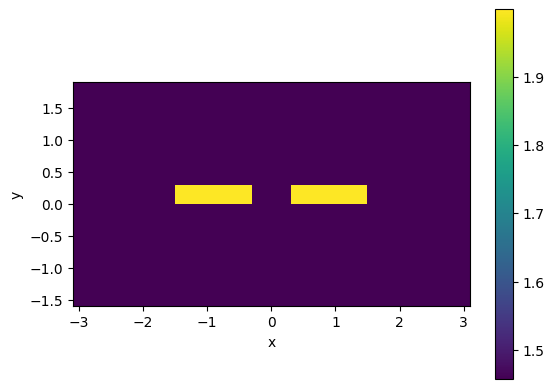

In [5]:
lambda_c = 1.55

dcoupler_cs = gt.modes.WaveguideCoupler(
    # Geometrical Parameters
    core_width=(1.2, 1.2), # Waveguide width
    slab_thickness=0 * nm, # For shallow waveguides - Set to 0 if its a deep-etched waveguide.
    core_thickness=300 * nm, # Waveguide height 
    gap=600 * nm,
    # Materials
    core_material='sin', #  Material of the waveguide
    clad_material='sio2', # Surrounding material
    # Modesolver Parameters
    wavelength=lambda_c, # Wavelength to simulate
    num_modes=4, # Number of modes to find
    #cache_path='C:/Users/CamiloCano/Desktop/Sims', # Important! In order to save simulation time, set your cache Path!
    precision='double',
    max_grid_scaling=1.5, # Parameters of the grid
    grid_resolution=20 # Parameters of the grid
)

dcoupler_cs.plot_index()

### 1.3. Simulations

#### 1.3.1. Parameters

As before, we can calculate the effective index (n_eff), TE and TM fraction for this cross-section using the already implemented class methods: .n_eff, .fraction_te and .fraction_tm. Remember that we will calculate one effective index for each mode (up to num_modes)

In [6]:
dcoupler_neff = dcoupler_cs.n_eff
print(dcoupler_neff)

[1.60942484+1.02849974e-04j 1.60116589+9.83178135e-05j
 1.53540293+1.77367472e-04j 1.52057329+1.77190584e-04j]


In [7]:
dcoupler_cs.fraction_te

array([0.994898  , 0.99527537, 0.00888064, 0.01130183])

In [8]:
dcoupler_cs.fraction_tm

array([0.005102  , 0.00472463, 0.99111936, 0.98869817])

#### 1.3.2. Plots

We could also plot the fields for each mode identified. Remember: the 'Ex' field component corresponds to TE modes, while the 'Ey' field component corresponds to TM modes. In the case of the directional coupler, the even and odd modes play a key role in facilitating energy exchange between the waveguides. Now, let's plot and analyze their behavior.

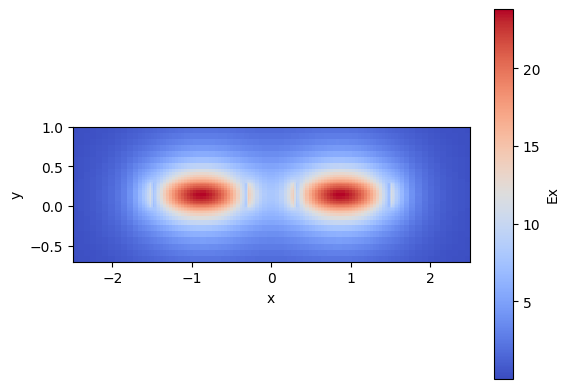

In [9]:
dcoupler_cs.plot_field(mode_index=0 , # Mode to be plotted
                          field_name='Ex', # Field to be plotted
                          value='real', # Real - abs - imag
                          cmap='coolwarm', # Suggestions: Change the plot color
                          xlim=(-2.5, 2.5), # Set the x and y limits
                          ylim=(-0.7, 1)
) # 

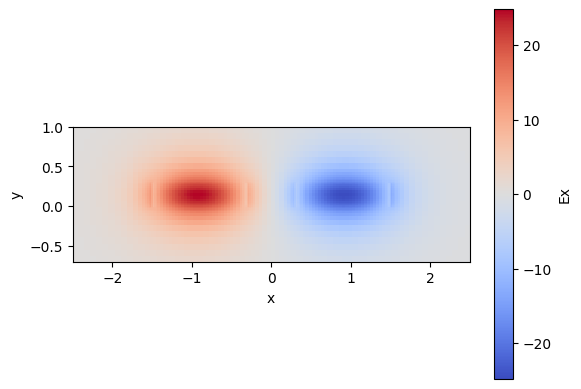

In [10]:
dcoupler_cs.plot_field(mode_index=1 , # Mode to be plotted
                          field_name='Ex', # Field to be plotted
                          value='real', # Real - abs - imag
                          cmap='coolwarm', # Suggestions: Change the plot color
                          xlim=(-2.5, 2.5), # Set the x and y limits
                          ylim=(-0.7, 1)) # 

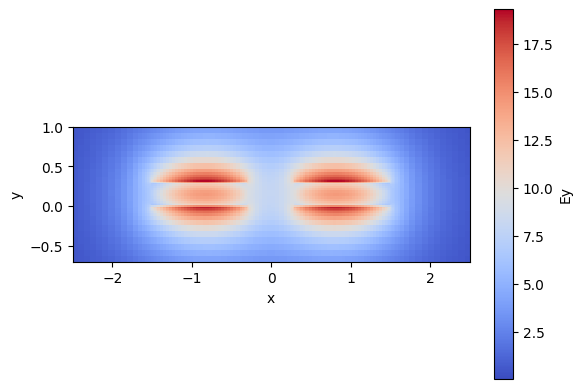

In [11]:
dcoupler_cs.plot_field(mode_index=2 , # Mode to be plotted
                          field_name='Ey', # Field to be plotted
                          value='real', # Real - abs - imag
                          cmap='coolwarm', # Suggestions: Change the plot color
                          xlim=(-2.5, 2.5), # Set the x and y limits
                          ylim=(-0.7, 1)) # 

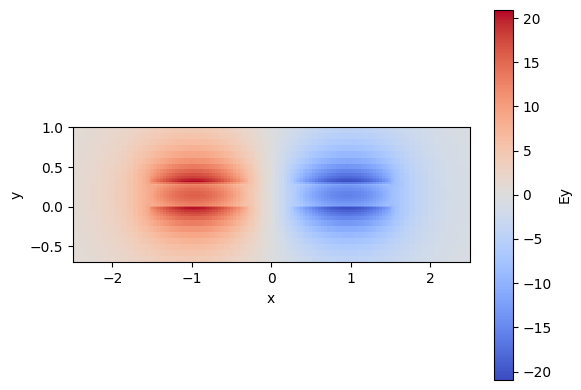

In [12]:
dcoupler_cs.plot_field(mode_index=3, # Mode to be plotted
                          field_name='Ey', # Field to be plotted
                          value='real', # Real - abs - imag
                          cmap='coolwarm', # Suggestions: Change the plot color
                          xlim=(-2.5, 2.5), # Set the x and y limits
                          ylim=(-0.7, 1)) # 

#### 1.3.3. Beating or Coupling Length calculation (𝐿𝜋)

The key parameter that determines the design of a directional coupler is the coupling or beating length. This length defines the total size of the coupling region required to transfer all the optical power from one waveguide to another. It is determined by the difference between the effective indices of the cross-section's odd and even modes:

In [13]:
# TE Modes: Modes 0 & 1
L_pi_TE = 0.5*lambda_c/(dcoupler_neff[0].real-dcoupler_neff[1].real)
print(L_pi_TE)

L_pi_TM =  0.5*lambda_c/(dcoupler_neff[2].real-dcoupler_neff[3].real)
print(L_pi_TM)

93.83767536696716
52.260223677440635


GDSFactory has its own method implemented to calculate the coupling length: [.coupling_length()](https://gdsfactory.github.io/gplugins/_autosummary/gplugins.tidy3d.modes.WaveguideCoupler.html)

In [14]:
dcoupler_cs.coupling_length()

array([93.83767537, 52.26022368])

## LO.2. Directional coupler length and coupling coefficient

The total power transferred to the output is modeled using the coupling coefficient (K). This coefficient depends on the relationship between the physical length of the coupling region and the beating length:

<img src="k.png" alt="Coupling Coefficient Equation" width="400">

In [14]:
# TE Modes: Modes 0 & 1
L_pi_TE = 0.5*lambda_c/(dcoupler_neff[0].real-dcoupler_neff[1].real)
print(L_pi_TE)

L_coup = ... # Student code here

K = ... # Student code here

plt.figure(figsize=(10, 5))
plt.plot(L_coup/L_pi_TE, K)
plt.xlabel("L_coup/L_pi (um)")
plt.ylabel("K")
plt.grid()
plt.tight_layout(rect=[0, 0, 0.85, 1])

93.83767536696716


TypeError: unsupported operand type(s) for /: 'ellipsis' and 'float'

<Figure size 1000x500 with 0 Axes>

## LO.3. 2x2 Directional Coupler

Here, you will use some functions provided by us (check **0. Imports** for more details) to simulate the propagation in a 2x2 directional coupler. Please read all the comments in the following code carefully and **make changes only to the lines marked with the #Student tag**

In [15]:
# Simulation flow for Directional Couplers
# Define your geometrical parameters here
wg_gap = 0.6 # Student. Gap between waveguides
wg_width = 1.2 # Student. Core waveguides width

d = wg_width + wg_gap
wg_N = 2

m = DC_EME() # Here you instantiate a Directional Coupler to be simulated with the Eigen-mode expansion (EME) algorithm.
m.MMI_num_modes = 12 # Number of modes to be calculated. Here, the higher, the better since we are going to calculate
                    # the propagation based on the mode decomposition. 
m.DC_wg_gap = wg_gap # Gap between waveguides
m.DC_wg_width = wg_width # Width of the waveguides core
m.DC_N_waveguides = wg_N

# 1) Compute de DC modes - Only execute whenever a geometrical parameter is changed. Takes time to find the modes. 
m.find_all_modes()

# 2) Get the L_pi 
L_pi = m.get_L_pi()
print("L_pi = ", L_pi, " µm")

c:\Users\camil\Documents\GitHub\pdk_UPVfab_v2\.venv\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


L_pi =  94.02742605181183  µm


c:\Users\camil\Documents\GitHub\pdk_UPVfab_v2\.venv\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


  0%|          | 0/2 [00:00<?, ?it/s]

1024


  0%|          | 0/940 [00:00<?, ?it/s]

------- Pameters -------
MMI length 47.0137
MMI length increment 0.0000
IO wg width 1.0000
IO wg width increment 0.0000
------------------------
Total power IN coupled 0.9688
Total OUT power: 0.9583
Excess loss [dB] =  0.1851
------------------------
Power over OUTs:  ['0.4791', '0.4791']
Ratio over OUTs ['0.5000', '0.5000']


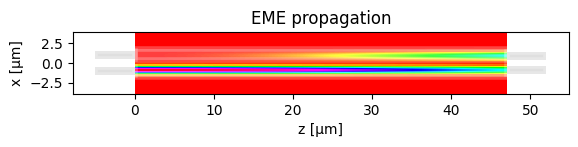

In [16]:
# IMPORTANT!!! 
# # If you DON'T change any geometrical parameter
# (waveguide widths or gap) you can skip last cell. 
# YOU CAN RUN the lines below as many times as you wish
# (SAVES TIME)

# 3) Configure DC
# DC I/O number
m.n_IN = 2
m.n_OUT = 2

m.L_MMI = 0.5*L_pi # Since we use the same library for propagation simulations of MMI and DC 
                    # some variables might be identified as "MMI". Sorry about that (: 
                    # Might change in the future 

# 4) Run propagation - get power transfer and plot propagation
m.propagation()

## LO.4. Multimode Interference (MMI) Coupler cross-section

### 1.1. Cross-Section definition and simulation

In GDSFactory - Tidy3d modesolver, we can simulate the Cross-Section of a multimode interference coupler using the previously studied : [gt.modes.Waveguide()](https://gdsfactory.github.io/gplugins/_autosummary/gplugins.tidy3d.modes.Waveguide.html) function. The parameters will correspond to the dimensions of the MMI body section. 

In [18]:
mmi_body_w = 12  
lambda_c = 1550*nm

mmi_body_waveguide = gt.modes.Waveguide(
    # Geometrical Parameters
    core_width=mmi_body_w, # MMI Body width
    core_thickness=300 * nm, # MMI Body height 
    slab_thickness=0 * nm, # For shallow waveguides - Set to 0 if its a deep-etched waveguides.
    # Materials
    core_material='sin', #  Material of the waveguide
    clad_material='sio2', # Surrounding material
    # Modesolver Parameters
    wavelength=lambda_c, # Wavelength to simulate
    num_modes=15, # Targeted number of modes to find - Higher than before! It's a multimode section
    max_grid_scaling=1.5, # Parameters of the grid
    grid_resolution=20, # Parameters of the grid
    #cache_path='C:/Users/CamiloCano/Desktop/Sims', # Important! In order to save simulation time, set your cache Path!
    precision='double',
)

mmi_body_waveguide.n_eff

23:19:12 Hora de verano romance WARNING: The group index was not computed. To   
                                calculate group index, pass 'group_index_step = 
                                True' in the 'ModeSpec'.                        

array([1.6786595 +7.78934672e-05j, 1.67512732+7.81571827e-05j,
       1.66922847+7.86028340e-05j, 1.66094525+7.92401466e-05j,
       1.65025312+8.00839409e-05j, 1.63712124+8.11557006e-05j,
       1.6215135 +8.24863265e-05j, 1.60339058+8.41212350e-05j,
       1.58271457+8.61311110e-05j, 1.5774205 +1.66068730e-04j,
       1.57388942+1.66498915e-04j, 1.56799588+1.67223410e-04j,
       1.55972723+1.68258130e-04j, 1.5594584 +8.86366847e-05j,
       1.54906903+1.69617736e-04j])

In [19]:
mmi_body_waveguide.fraction_te

array([9.99991904e-01, 9.99967183e-01, 9.99924497e-01, 9.99861445e-01,
       9.99774272e-01, 9.99657368e-01, 9.99502382e-01, 9.99296461e-01,
       9.99013009e-01, 2.38565216e-04, 9.55099424e-04, 2.13831793e-03,
       3.73633927e-03, 9.98594348e-01, 5.78997522e-03])

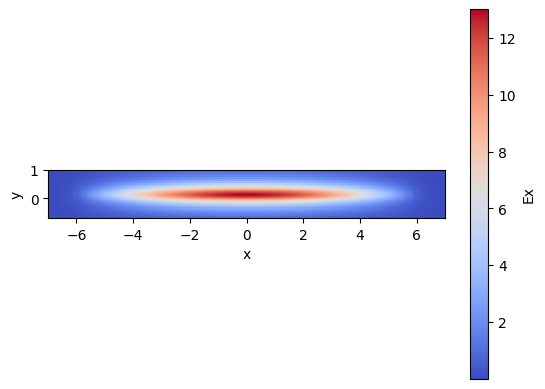

In [20]:
mmi_body_waveguide.plot_field(mode_index=0 , # Mode to be plotted
                          field_name='Ex', # Field to be plotted
                          value='real', # Real - abs - imag
                          cmap='coolwarm', # Suggestions: Change the plot color
                          xlim=(-7, 7), # Set the x and y limits
                          ylim=(-0.7, 1)
) # 

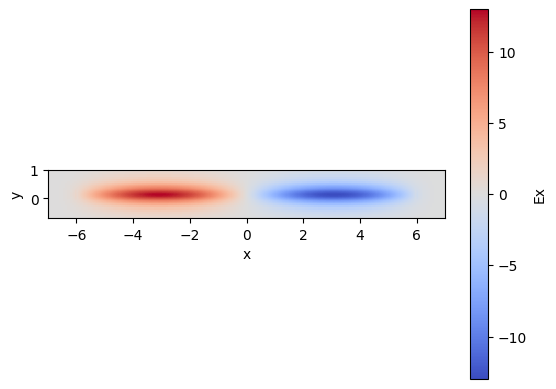

In [21]:
mmi_body_waveguide.plot_field(mode_index=1 , # Mode to be plotted
                          field_name='Ex', # Field to be plotted
                          value='real', # Real - abs - imag
                          cmap='coolwarm', # Suggestions: Change the plot color
                          xlim=(-7, 7), # Set the x and y limits
                          ylim=(-0.7, 1)) # 

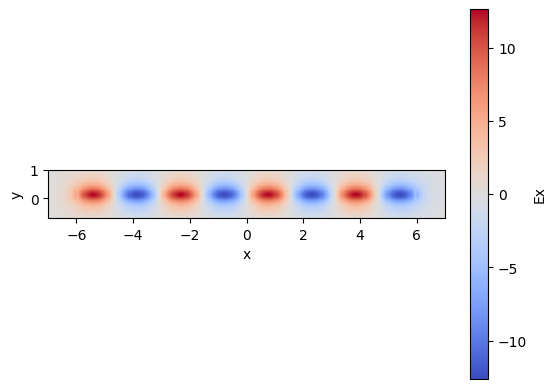

In [22]:
mmi_body_waveguide.plot_field(mode_index=7, # Mode to be plotted
                          field_name='Ex', # Field to be plotted
                          value='real', # Real - abs - imag
                          cmap='coolwarm', # Suggestions: Change the plot color
                          xlim=(-7, 7), # Set the x and y limits
                          ylim=(-0.7, 1)) #

#### 1.1.2 Beating Length calculation (𝐿𝜋)

With this information, we could calculate our first guess for the beating length (𝐿𝜋) of the MMI coupler:

In [23]:
d_n_eff = mmi_body_waveguide.n_eff[0].real -  mmi_body_waveguide.n_eff[1].real

L_pi = 0.5*lambda_c/(d_n_eff)

print (L_pi)

219.41119794411597


## LO.5. 2x2 Multimode Interference Coupler 

For the multimode interference (MMI) couplers we must rely on the design tables shown on the theoretical session: 

<img src="mmi.png" alt="Design tables for MMI couplers" width="600">

Here, you will use some functions provided by us (check **0. Imports** for more details) to simulate the propagation in a 2x2 directional coupler. Please read all the comments in the following code carefully and **make changes only to the lines marked with the #Student tag**

In [24]:
# Simulation flow for MMI Couplers
# Define your geometrical parameters here
mmi_Width = 12  # Student. Body width

m = MMI_EME() # Here you instantiate a MMI to be simulated with the Eigen-mode expansion (EME) algorithm.
m.MMI_width = mmi_Width
m.MMI_num_modes = 12 # Number of modes to be calculated. Here, the higher, the better since we are going to calculate
                    # the propagation based on the mode decomposition. 

# 1) Compute de MMI body modes - Only execute whenever a geometrical parameter is changed. Takes time to find the modes. 
m.find_all_modes()

# 2) Get the L_pi 
L_pi = m.get_L_pi()
print("L_pi = ", L_pi, " µm")

c:\Users\camil\Documents\GitHub\pdk_UPVfab_v2\.venv\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


L_pi =  219.1393154410822  µm


c:\Users\camil\Documents\GitHub\pdk_UPVfab_v2\.venv\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


  0%|          | 0/9 [00:00<?, ?it/s]

1024


  0%|          | 0/2191 [00:00<?, ?it/s]

------- Pameters -------
MMI length 109.5697
MMI length increment 0.0000
IO wg width 1.0000
IO wg width increment 0.0000
------------------------
Total power IN coupled 0.8471
Total OUT power: 0.6953
Excess loss [dB] =  1.5782
------------------------
Power over OUTs:  ['0.3484', '0.3469']
Ratio over OUTs ['0.5011', '0.4989']


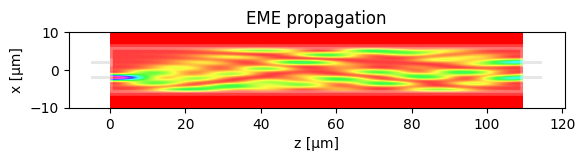

In [25]:
# IMPORTANT!!! 
# # If you DON'T change neither the MMI width 
# nor input/output waveguide widths
# YOU CAN RUN the lines below as many times as you wish
# (SAVES TIME)

# 3) Configure MMI
# # MMI I/O number (check class slides for type of MMI)
m.n_IN =  2 # STUDENT
m.n_OUT = 2 # STUDENT

# MMI I/O waveguide positions (check class slides for type of MMI)
m.IN_WVG_positions = m.MMI_width * np.array([-1/6,1/6]) # STUDENT
m.OUT_WVG_positions = m.MMI_width * np.array([-1/6,1/6]) # STUDENT

# MMI length (check class slides for type of MMI)
m.L_MMI = L_pi/2 # STUDENT

# Run propagation
m.propagation()